# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd

from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

tf.config.optimizer.set_jit(True)  #setting the XLA (Accelerated Linear Algebra) flag 

# # Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


2024-01-17 01:09:33.023146: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 01:09:33.069375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 01:09:33.069427: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 01:09:33.069438: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 01:09:33.077915: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-01-17 01:09:35.764590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 01:09:35.810928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 01:09:35.811217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
directory_path = "/home/ubuntu/Thesis/quijote/" # add path to the data directory

## Loading the Data
We are considering $k_{max} = 0.2$ "mildly linear" case. The data "df" contains the normalized parameters and summary statistics in one single data frame. The data "df_lbl" contains the normalised parameters. The summary statistics used here are power spectrum (P0_0 - P0_31),
marked power spectrum(MP0, MP01, MP02, MP04 each with 32 entries eg. MP0_0 - MP0_31), bispectrum(B_0 - B_72),marked bispectrum(MB, MB1, MB2, MB4 each with 67 entries from MB_0 -MB_66) and halo mass function(HMF_0-HMF_11). The labels contains the parameters $f_{NL}^{eq}$,$\Omega_m$,$h$,$n_s$,$\sigma_8$

In [4]:
# # Reading the data

# pk = pd.read_csv(directory_path+"Pk_lh.csv")[:80].T                      # taking transpose to keep in check the dimensionality
# pk.reset_index(drop = True,inplace=True)                            # dropiing index for concatenating the P_k data with the parameters 
# params = pd.read_csv(directory_path+"lh_params.csv",index_col= 0)   # laoding the vanilla parameters data

# #normalising the parameters
# mean_params = params.mean(axis=0).values
# std_params = params.std(axis = 0).values
# norm_params = (params - mean_params)/std_params

# # Concatenating the params and pk

#df = pd.concat([norm_params,pk],axis = 1)


# P_k = df[df.columns[5:]]
# van_labels = df[df.columns[:5]]


## Reading the Data
df_all = pd.read_csv(directory_path + "data_lh_0pt5.csv")

## Unnormalised parameters
df_lbl = pd.read_csv(directory_path + "unnormalised_lbl.csv")
mean_params = df_lbl.mean(axis=0).values # mean of params
std_params = df_lbl.std(axis = 0).values # standard deviation of params
cov_params = df_lbl.cov().values





#### Creating different datasets for different summary statistics.

In [5]:
# PARMAETERS AND SUMMARY STATISTICS 
"""
sliced the main dataset into different statistics
"""
norm_lbl = df_all.loc[:,'fnl_equil':'s8']
P0  = df_all.loc[:,'P0_0':'P0_79']
MP0 = df_all.loc[:,'MP01_0':'MP04_79']
B0  = df_all.loc[:,'B_0':'B_72']
MB  = df_all.loc[:,'MB1_0':'MB4_66']
HMF = df_all.loc[:,'HMF_0':'HMF_11']
MP0_0 = df_all.loc[:,'MP0_0':'MP0_79']
MB0  = df_all.loc[:,'MB_0':'MB_66']


In [6]:
# Function to create input data fot combination of summary statistics

def input_data(columns,norm_lbl):
    
    """
    columns: it takes a list input of the summary statistics
    norm_lb: it is the normalised label of the parameters
    selects the different summary statistics 
    to make it into a single dataframe, which 
    can then be used as the input in the NN.
    """
    
    assert isinstance(columns, list), "Input is not a list"
    df_columns = pd.concat(columns,axis =1)
    
    return pd.concat([norm_lbl,df_columns],axis=1)


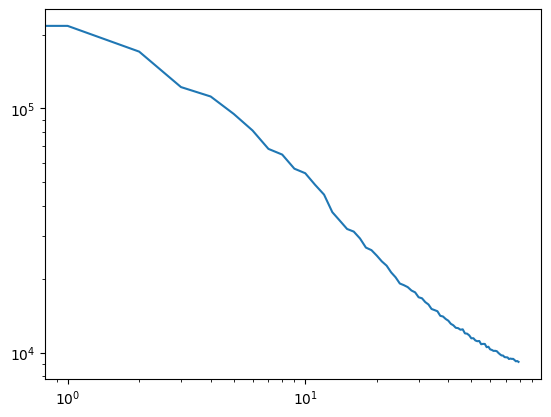

In [7]:
#Plotting the power spectrum
plt.plot(P0.T[1])             # Transposing to plot power spectrum for each simulation 
plt.loglog()
plt.show()


#### Data splitting into Train, Validation and Test set

In [8]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    
    """
    df: The input dataframe
    params: the number of params default set to 5. Change if adding more parameters
    train_frac: fraction of training data
    test_frac: fraction of test data
    """
    
    # Permuting the DataFrame to avoid any bias.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

# Define couple of useful functions

#### Defining the loss plot function

In [9]:
# Function defining loss plot.

def plot_loss(df_history, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(df_history.index, df_history['loss'], label='Training_loss')
    plt.plot(df_history.index, df_history['val_loss'], label='Validation_loss')

    
#     for key, history in histories.items():
#         plt.plot(
#             np.array(range(len(history.history['val_loss'])))-0.5, 
#             history.history['loss'], 
#             label='loss'
#         )
#         plt.plot(history.history['val_loss'], label='val_loss')

    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

#### LaTex Label Names

In [10]:
label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

label_LaTeX_names_equilateral = [r"$f_{NL}^{eq}$", 
                                 r"$\Omega_m$",
                                 r"$h$",
                                 r"$n_s$",
                                 r"$\sigma_8$"]

#### Defining Elu+1 activation function
Used for positive definiteness of the Sigma outputs. ELU gives a negative output however for the sigma values we need a positive definiteness so ELU+1 helps with that

In [11]:
def elu_plus_one(input):

    """ Adds one to the Exponential Linear Unit

    """

    return tf.add(

       tf.nn.elu(input),

        tf.constant(1.0000001, dtype=tf.float32) # Notice I added 1.e-7 for stability

    )

tf.keras.utils.get_custom_objects().update({'elu_plus_one': layers.Activation(elu_plus_one)})

##############################################################################################################################

# Analysis

#############################################################################################################################

## Building the model
Creating layers and defining hyperparameter tuninig.

In [12]:
def hp_model_for_dataset():
    class MyHyperModel(kt.HyperModel):
        def build(self, hp):
            #############################   Hyper-tuning Parameters  #############################
            num_layers = hp.Int('num_layers', min_value=1, max_value= 8) #3
            architecture = [hp.Int(f"unit_num_{i}", min_value=32, max_value=1024, step=32) for i in range(num_layers)]  #[384, 96, 256]
            dropout_rate =  hp.Float('dropout_rate',min_value= 0.1, max_value= 0.5, sampling="log") #0.10320930206682662
            opt_learning_rate = hp.Float('learning_rate',min_value= 1e-5, max_value= 1e-2, sampling="log") #optimizer learning rate 0.00030932800521408247 #
            regularization_rate = hp.Float('l2_regularization', min_value=1e-5, max_value=1e-2, sampling="log")


            #############################   Creating Layers  #############################
            """
            We take the input normalise it and name it input_layer. 
            
            Then, we Iterate through the nodes in the  specified architecture, 
            adding dense layers (d_layer) with SELU activation and He normal initialization.
            
            In each iteration of the loop, a dense layer (d_layer) is created 
            and connected to the current input layer (input_layer).
            After that, a dropout layer is applied to the output of the dense layer,
            and the variable input layer is updated to hold the output of the dropout layer.
            The name input_layer is misleading but, it effectively represents the output of the previous layer 
            and is updated to reflect the current layer's output in each iteration.
            """
            # The features are normalized to have mean=0 and std=1
            inputs = Input(shape=X_training_set.shape[1])
            normalize_layer = layers.Normalization()
            normalize_layer.adapt(X_training_set)
            norm_inputs = normalize_layer(inputs)
            input_layer = norm_inputs

            # Adding hidden dense layers which is specified by the architecture
            for n_nodes in architecture:
                d_layer = layers.Dense(
                    n_nodes,
                    activation="selu",
                    kernel_initializer="he_normal",
                    # kernel_regularizer=regularizers.l2(regularization_rate)
                )(input_layer)
    
                # Each is followed by a dropout layer to apply dropout regularization
                input_layer = layers.Dropout(dropout_rate)(d_layer)
            
            
            # Add the output layer combining means and sigmas
            # last_hidden_layer = input_layer
      
        ########################################## Defining Ouputs #################################################################         
            """
            the code extends the neural network to predict means and pseudo-sigmas for multiple target variables.
            The means are predicted using a standard dense layer,
            while the pseudo-sigmas are predicted using a specialized initializer'initializer_pseudo_sigmas'
            and a dense layer (with L2 regularization?-gives better results?).
            The final output layer combines both predictions.
            """
            
            ###############################################################################################################
            
            target_variable_number = y_training_set.shape[-1]
            
            def initializer_pseudo_sigmas(shape, dtype=None):
                
                return ((0.5*tf.ones(shape)+tf.random.uniform(shape))/ np.sqrt(shape[0])/10.
                        * tf.cast(tfpmath.fill_triangular_inverse(np.identity(target_variable_number)), dtype=dtype) )
                
#           ##############################################################################################################
            
          
            
            
            means = layers.Dense(target_variable_number,
                                 activation="linear",
                                 kernel_initializer="he_normal")(input_layer) #(last_hidden_layer)
            
            
            
            pseudo_sigmas = layers.Dense(target_variable_number*(target_variable_number+1)/2,
                                         activation="linear",
                                          kernel_initializer=initializer_pseudo_sigmas,
                                         kernel_regularizer=regularizers.l2(regularization_rate)
                                        )(input_layer) #(last_hidden_layer)initializer_pseudo_sigmas
            
            output_layer = layers.Concatenate()([means, pseudo_sigmas])
                        

            #############################   Creating Model  #############################
            """
            The model is compiled using a custom loss function (mse_means_and_sigmas_uncorrelated) and 
            the Adam optimizer with a specified learning rate (opt_learning_rate).
            """
            model = Model(inputs=inputs, outputs=output_layer)
            

            model.compile(
                loss=mse_means_and_sigmas_uncorrelated,
                optimizer=tf.optimizers.Adam(learning_rate= opt_learning_rate),
            )
            # model.summary()

            return model

        def load_best_weights(self, model):
            model.load_weights('best_weights.h5')
            return model
        
        def fit(self, hp, model, *args, callbacks=[], **kwargs):
            """
            fit method is defined to train the model.
            A cyclic learning rate (CLR) callback is utilized during training, 
            cyclically adjusting the learning rate.
            We are hyper-tuning the batch_size and the hp_base_learning_rate.
            """
            
            #############################   Hyper-tuning CLR and batch size #############################
           
            batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512])
           
            hp_base_learning_rate =  hp.Float('base_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")#9.365959093508116e-05
            print("Cyclic lR:",hp_base_learning_rate)
            
            # checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            #     'best_weights.h5',
            #     monitor='val_loss',
            #     save_best_only=True,
            #     save_weights_only=True,
            #     mode='min',
            # verbose=1
            # )
            clr_triangular = CLR.CyclicLR(
                base_lr=hp_base_learning_rate,
                max_lr=hp_base_learning_rate * 4.,
                step_size=3 * 4,  # recommended (2-8) x (training iterations in epoch)
                gamma=0.99994)
            
            return model.fit(
                *args,
                callbacks=callbacks + [clr_triangular],#,checkpoint_callback],
                batch_size=batch_size,
                **kwargs
            )

    return MyHyperModel()

            ##################################### MMN ###############################################
           
            # # sigmas = layers.Dense(target_variable_number, activation="elu_plus_one")(input_layer)
            # # output_layer = layers.Concatenate()([means, sigmas])
            
            ########################################################################################


            ############  Trial output with mean, diagonal elements of L,off-diagonal################        
            
            # # Define the means layer
            # means = layers.Dense(target_variable_number, activation="linear", kernel_initializer="he_normal")(input_layer)
            
            # # Define the L layer
            # L_diagonal = layers.Dense(target_variable_number,
            #                           activation="elu_plus_one",
            #                          # kernel_regularizer=regularizers.l2(regularization_rate)
            #                          )(input_layer)
            # L_off_diagonal = layers.Dense((target_variable_number * (target_variable_number - 1))/2,
            #                               activation="linear",
            #                               kernel_initializer="he_normal",
            #                              # kernel_regularizer=regularizers.l2(regularization_rate)
            #                              )(input_layer)
            
            
            # output_layer = layers.Concatenate()([means, L_diagonal, L_off_diagonal])
            ########################################################################################

## Defining loss

In [13]:
# def log_sum_exp(x, axis=None):
#         x_max = tf.reduce_max(x, axis=axis, keepdims=True)
#         return tf.math.log(tf.reduce_sum(tf.exp(x - x_max), axis=axis, keepdims=True)) + x_max

In [14]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    # ######################################## WITHOUT COV ############################################################
    # means_pred, sigmas_pred = tf.split(y_pred, num_or_size_splits=2, axis=1)
    
    # y_true = tf.cast(y_true, dtype=y_pred.dtype) 
    
    # squared_differences = tf.math.square(y_true - means_pred)
    # sigmas2_sigma = tf.math.reduce_mean(tf.math.square(squared_differences - tf.math.square(sigmas_pred)), 0)
    # sigmas2 = tf.math.reduce_mean(squared_differences, 0) 

    # loss = tf.math.reduce_mean(tf.math.log(sigmas2) + tf.math.log(sigmas2_sigma))
    # #loss = tf.math.reduce_mean(sigmas2 + sigmas2_sigma)
    # return loss
    # #################################################################################################################
    """ code to evaluate the Gaussian likelihood loss function.

    It assumes that the last dimension of the tensor (i.e. the number of estimated parameters)

    is n+n*(n+1)/2, where n is the number of estimated means.

    The first n entries are interpreted as the means, and the following n*(n+1)/2 are the

    coefficients of the Cholensky decomposition of the covariance, as ordered by

    tensorflow_probability.math.fill_triangular_inverse.
    
    The user-defined loss function in TensorFlow takes
    two arguments (y_true,y_predict). To find the number of parameters from the total number of entries(k = y_pred.shape[-1]) which is also
    the dimension of the output tensor, we can solve
    the equation k = n + n*(n+1)/2.
    
    Arguments:

    y_true -- tensor with last dimension equal to n

    y_pred -- tensor with last dimension equal to n+n*(n+1)/2

    """
  
    num_of_parameters=tf.cast((tf.math.sqrt(tf.cast(8*y_pred.shape[-1]+9, dtype=tf.float16))-3)/2, dtype=tf.int32)


    means_pred,pseudo_sigmas_pred = tf.split(y_pred,# L_dig_pred,L_offdig_pred

                                              num_or_size_splits=[

                                                  num_of_parameters,
                                                  # num_of_parameters,

                                                  tf.cast(num_of_parameters*(num_of_parameters+1)/2, dtype=tf.int32)

                                              ], axis=-1)
    L = tfpmath.fill_triangular(pseudo_sigmas_pred)
   
    dist = distributions.MultivariateNormalTriL(

        loc=means_pred,

        scale_tril=L,

    )
    

    loglkl = dist.log_prob(y_true)

    return -tf.math.reduce_mean(loglkl)
    
    
    
    ############ For the ouput with mean L_diagona and L Off diagonal #######
     # padding = [[0, 0], [1, 0], [0, 1]]
    # L_off = tf.pad(tfpmath.fill_triangular(L_offdig_pred),padding,"CONSTANT")
    # L = tf.linalg.set_diag(L_off,L_dig_pred)
    ########################################################################
    # cov = tf.matmul(L,tf.transpose(L))

    # tf.print()

    # tf.print(L_dig_pred)
    # tf.print(L_offdig_pred)
    # tf.print(L)

    
    
    
    # shape_loglkl = tf.shape(loglkl)
    # min_loglkl = tf.reduce_min(loglkl)
    # argmin_index = tf.argmin(loglkl)
    # reduce_mean = -tf.math.reduce_mean(loglkl)

    # tf.print(shape_loglkl,min_loglkl,argmin_index,reduce_mean)

    # selected_means_pred = tf.gather(means_pred, argmin_index)
    # selected_L = tf.gather(L, argmin_index)
    # tf.print(selected_means_pred)
    # tf.print(selected_L)
   

    
  

## Define callbacks

In [15]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


In [16]:
def callback_early_stopping(monitor='val_loss', patience=100): #, max_delta=50):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        # min_delta=50,
        patience=patience,
        restore_best_weights=True,
        verbose=0,
        mode='min'
    )

    lossHistory = LossHistory()
    # custom_early_stopping = CustomEarlyStopping()
    #     max_delta=max_delta,
    #     patience=patience,
        
        
        
    # )
    return [early_stopping,lossHistory]#,custom_early_stopping]

## Define some ancillary stuff

In [17]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()

In [18]:
# prediction of parameters
def prediction(model,X_test_set,y_test_set,mean_params,std_params,title):
    
    """
    Predicts and evaluates model performance on the test set.

    Parameters:
    - model: The trained model.
    - X_test_set: Test set features.
    - y_test_set: True labels for the test set.
    - mean_params: Mean values used for normalization.
    - std_params: Standard deviation values used for normalization.
    - title: A string describing the summary statistics used.

    Returns:
    - Prints and plots model predictions and evaluation metrics.
    """
    
    assert isinstance(title, str), "Title must be a string"
    
    predictions = model.predict(X_test_set, verbose=0)
    
    df_predictions = pd.DataFrame(predictions) 
    y_mean_predict = df_predictions[df_predictions.columns[:5]]
    y_cov_predict = df_predictions[df_predictions.columns[5:]]
    
    """
    takes the lower triangular part of the covariance predictions,
    fills it to reconstruct the full covariance matrix, 
    and then extracts the standard deviations from the diagonal elements of the covariance matrix. 
    """
    
    L = tfpmath.fill_triangular(y_cov_predict)
    cov_matrix = tf.matmul(L,L, transpose_b=True)
    y_sigma_predict = tf.sqrt(tf.linalg.diag_part(cov_matrix))
    
    # y_sigma_predict = df_predictions[df_predictions.columns[5:]]
    
    true_y = ((y_test_set * std_params) + mean_params).reset_index(drop=True).values
    predict_y = ((y_mean_predict * std_params)  + mean_params).values
    predict_E = (y_sigma_predict*std_params).numpy()
    # print("Returns true_y, predict_y, predict_E, df_predictions")
    
    #Plot of Predicted, std_dev, Bias vs True 
    for j in range(len(mean_params)):
        check_predictions(
            true_y[:,j],
            predict_y[:,j],
            predict_E[:,j],
            label=label_LaTeX_names_equilateral[j],
            title= title)
    return (true_y,predict_y,predict_E,df_predictions,y_cov_predict)
    


# Tuning hyperparameters

# P0, B0,MP0_0,MB0,HMF

In [94]:
columns = [P0, B0,MP0_0,MB0,HMF]
df_3 = input_data(columns,norm_lbl)



In [95]:
X3_train, X3_val, X3_test, y3_train, y3_val, y3_test = train_val_test_split(df_3 ,random_state = 42 )


In [102]:
X_training_set = X3_train
y_training_set = y3_train

tuner3 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='keras_tuner_dir',
    project_name ='P0, B0,MP0_0,MB0,HMF reg-patience100-1', #trained with kernel regularizer for pseudo_sigma
    )


# Running the HyperParameter Search

tuner3.search(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=1000000, callbacks= callback_early_stopping())#100000




Reloading Tuner from keras_tuner_dir/P0, B0,MP0_0,MB0,HMF reg-patience100-1/tuner0.json


In [103]:
best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp3.get('num_layers')
best_architecture = [best_hp3.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp3.get('learning_rate')
best_dropout_rate = best_hp3.get('dropout_rate')
best_base_learning_rate = best_hp3.get('learning_rate')
best_batch_size = best_hp3.get('batch_size')
best_regularization_rate =best_hp3.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")
# -Regularization Rate:{best_regularization_rate}

# - Number of Layers: {best_num_layers}
# - Architecture: {best_architecture}
# -Base Learning Rate (CLR): {best_base_learning_rate}
# - Opt_Learning Rate: {best_learning_rate}
#- Dropout Rate: {best_dropout_rate}
print(tuner3.search_space_summary())
print(tuner3.results_summary())


Best Hyperparameters:
- Number of Layers: 8
- Architecture: [896, 704, 640, 672, 1024, 608, 608, 224]
- Opt_Learning Rate: 1e-05
- Base Learning Rate (CLR): 1e-05
- Dropout Rate: 0.1
- Batch Size: 256
- Regularization Rate:0.0002635175850944355

Search space summary
Default search space size: 14
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
l2_regularization (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 

In [104]:
best_model3 = tuner3.get_best_models()[0]
best_model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 312)]                0         []                            
                                                                                                  
 normalization (Normalizati  (None, 312)                  625       ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 896)                  280448    ['normalization[0][0]']       
                                                                                                  
 dropout (Dropout)           (None, 896)                  0         ['dense[0][0]']           

In [105]:
# Fitting the model
hypermodel3 = hp_model_for_dataset()
best_model3 = hypermodel3.build(best_hp3)
histories3= hypermodel3.fit(best_hp3,best_model3,
    X3_train,
    y3_train,
    validation_data=(X3_val,
                     y3_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df3_history = pd.DataFrame(histories3.history)

Cyclic lR: 0.0003495763298378854
Epoch 1/1000000
3/3 [==============================] - 4s 352ms/step - loss: 30.6616 - val_loss: 16.5937
Epoch 2/1000000
3/3 [==============================] - 1s 337ms/step - loss: 18.3813 - val_loss: 18.9516
Epoch 3/1000000
3/3 [==============================] - 0s 16ms/step - loss: 19.7301 - val_loss: 18.2844
Epoch 4/1000000
3/3 [==============================] - 0s 15ms/step - loss: 18.9077 - val_loss: 17.9547
Epoch 5/1000000
3/3 [==============================] - 0s 15ms/step - loss: 20.2383 - val_loss: 18.8608
Epoch 6/1000000
3/3 [==============================] - 0s 16ms/step - loss: 19.6015 - val_loss: 18.8008
Epoch 7/1000000
3/3 [==============================] - 0s 15ms/step - loss: 19.8711 - val_loss: 18.5232
Epoch 8/1000000
3/3 [==============================] - 0s 22ms/step - loss: 19.3543 - val_loss: 16.5727
Epoch 9/1000000
3/3 [==============================] - 0s 22ms/step - loss: 18.1960 - val_loss: 14.4708
Epoch 10/1000000
3/3 [=======

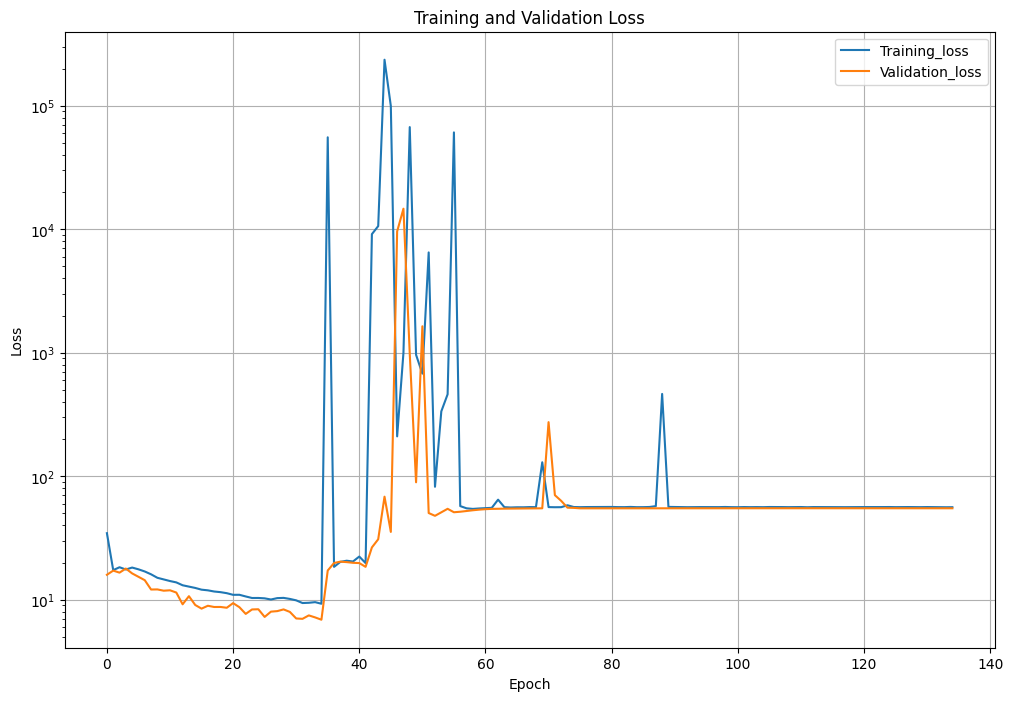

,loss,val_loss
0,34.631447,15.940795
1,17.393950,17.232590
2,18.344080,16.589737
3,17.596352,17.902462
4,18.239637,16.354971
...,...,...
130,56.353840,55.088531
131,56.272396,55.086746
132,56.282578,55.084820
133,56.145710,55.083275


In [100]:
# Loss Plot
plot_loss(df3_history, logy=True)#, ylim=[0, 25])
df3_history

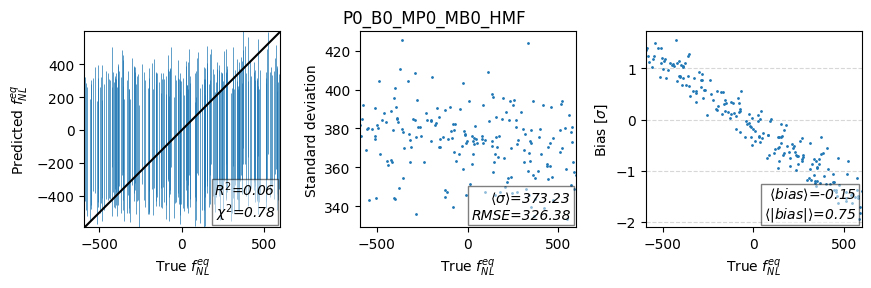

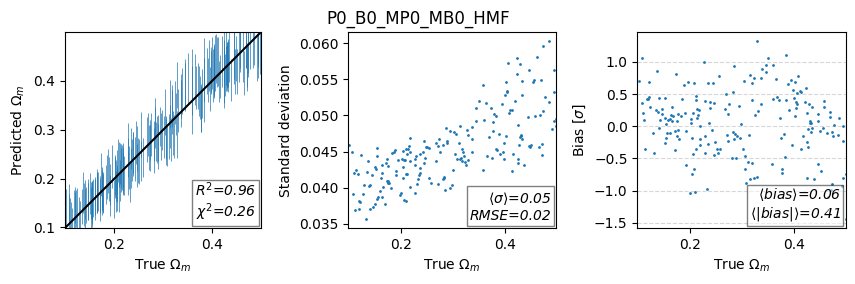

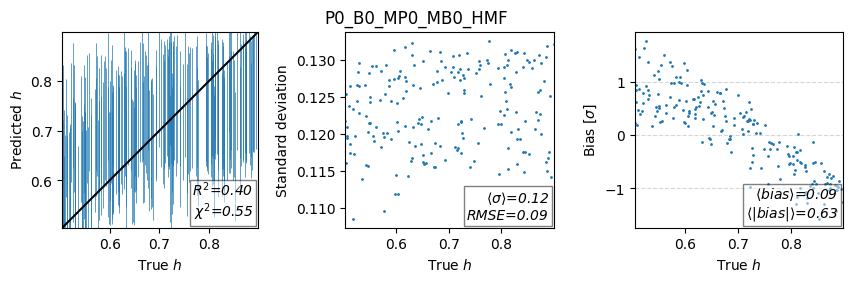

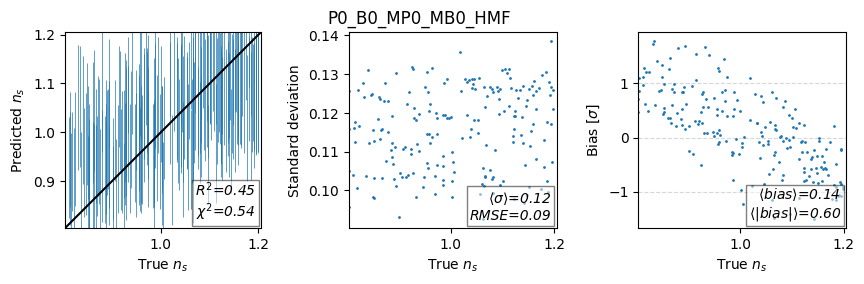

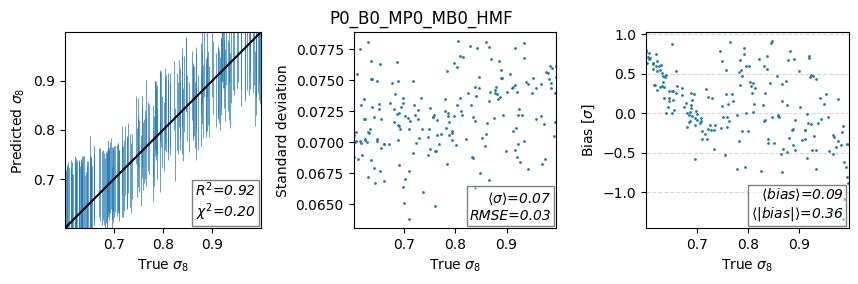

In [25]:
predictions3 = prediction(best_model3,X3_test,y3_test,mean_params,std_params,title = "P0_B0_MP0_MB0_HMF")


In [ ]:
# I havent implemented

# All summary statistic

In [45]:
#performing spitting
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_all,random_state = 1 )


In [47]:
X_training_set = X_train

# Instantiating the tuner
tuner = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='all_patience100-reg -1')
# Running the HyperParameter Search

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100000, callbacks=callback_early_stopping())





Trial 30 Complete [00h 00m 19s]
val_loss: 17.278366088867188

Best val_loss So Far: 2.537410259246826
Total elapsed time: 00h 12m 44s


#### Let us see the best hypertune parameters

In [48]:
print(tuner.search_space_summary())
print(tuner.results_summary())
# tuner.results_summary()

Search space summary
Default search space size: 14
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
l2_regularization (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
base_learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 

In [51]:
best_hp=tuner.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp.get('num_layers')
best_architecture = [best_hp.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp.get('learning_rate')
best_dropout_rate = best_hp.get('dropout_rate')
best_base_learning_rate = best_hp.get('learning_rate')
best_batch_size = best_hp.get('batch_size')
best_regularization_rate = best_hp.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")


Best Hyperparameters:
- Number of Layers: 7
- Architecture: [640, 512, 192, 160, 896, 384, 192]
- Opt_Learning Rate: 0.0011696660288383054
- Base Learning Rate (CLR): 0.0011696660288383054
- Dropout Rate: 0.16913201069919603
- Batch Size: 256
- Regularization Rate:0.00418646221272008



In [52]:
# Fitting the model
hypermodel = hp_model_for_dataset()
best_model = hypermodel.build(best_hp3)
histories= hypermodel.fit(best_hp,best_model,
    X_train,
    y_train,
    validation_data=(X_val,
                     y_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df_history = pd.DataFrame(histories.history)

Cyclic lR: 9.868974760966304e-05
Epoch 1/1000000
3/3 [==============================] - 5s 426ms/step - loss: 30.2236 - val_loss: 15.0449
Epoch 2/1000000
3/3 [==============================] - 1s 463ms/step - loss: 16.9696 - val_loss: 14.9190
Epoch 3/1000000
3/3 [==============================] - 0s 17ms/step - loss: 16.7133 - val_loss: 16.1102
Epoch 4/1000000
3/3 [==============================] - 0s 17ms/step - loss: 17.3404 - val_loss: 16.0763
Epoch 5/1000000
3/3 [==============================] - 0s 17ms/step - loss: 17.1674 - val_loss: 15.5654
Epoch 6/1000000
3/3 [==============================] - 0s 23ms/step - loss: 16.6566 - val_loss: 13.8817
Epoch 7/1000000
3/3 [==============================] - 0s 24ms/step - loss: 15.8256 - val_loss: 12.2368
Epoch 8/1000000
3/3 [==============================] - 0s 23ms/step - loss: 15.3400 - val_loss: 11.2625
Epoch 9/1000000
3/3 [==============================] - 0s 23ms/step - loss: 15.0545 - val_loss: 11.2115
Epoch 10/1000000
3/3 [=======

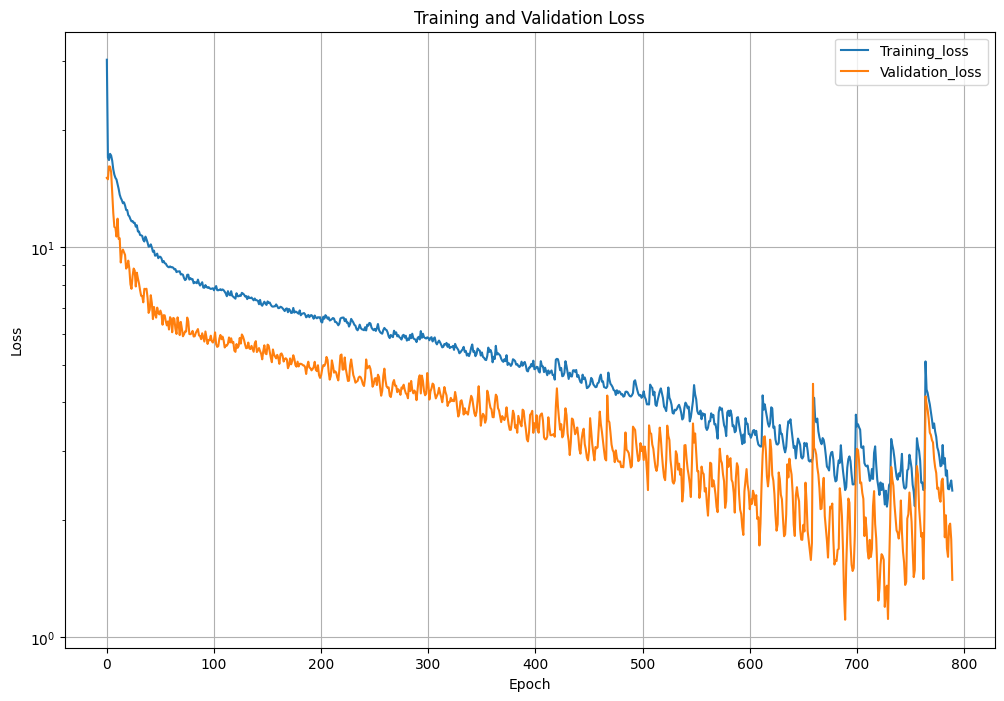

In [55]:
plot_loss(df_history, logy=True)#, ylim=[15, 25])

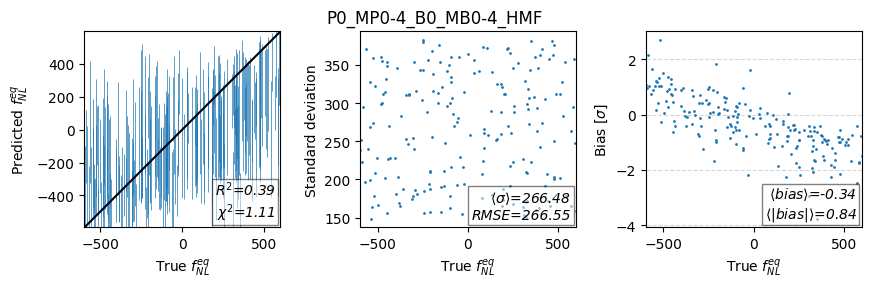

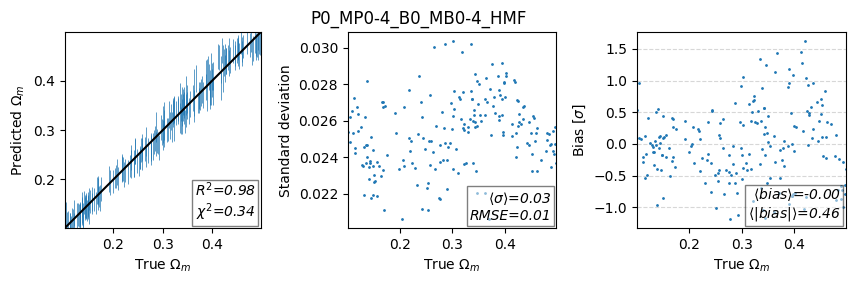

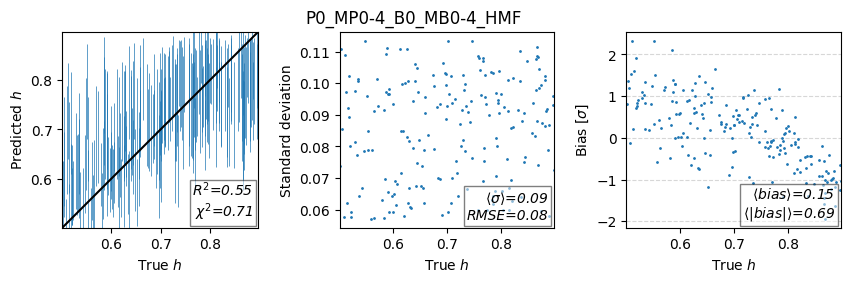

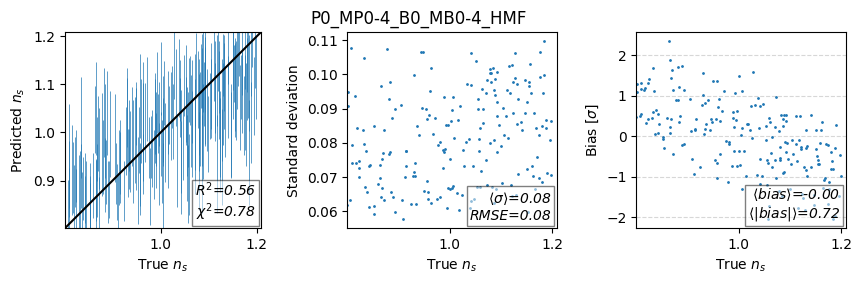

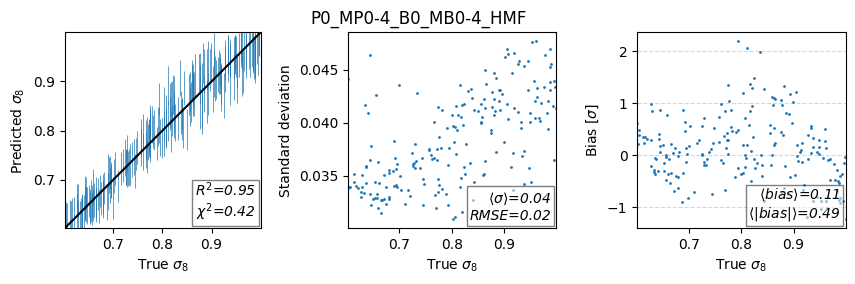

In [57]:
predictions = prediction(best_model,X_test,y_test,mean_params,std_params,title = "P0_MP0-4_B0_MB0-4_HMF")


#### Let us try a different set of summary statistics 

In [76]:
# Call the Data
columns = [P0, B0, HMF]
df_1 = input_data(columns,norm_lbl)


In [77]:
#Split 
X1_train, X1_val, X1_test, y1_train, y1_val, y1_test = train_val_test_split(df_1, random_state = 3)
X1_test

,P0_0,P0_1,P0_2,P0_3,P0_4,P0_5,P0_6,P0_7,P0_8,P0_9,...,HMF_2,HMF_3,HMF_4,HMF_5,HMF_6,HMF_7,HMF_8,HMF_9,HMF_10,HMF_11
804,2.340585e+06,1.541554e+06,1.013401e+06,566312.685728,407066.069983,321104.725693,281989.259236,275458.593362,300327.774732,274540.552188,...,1681,890,447,206,73,28,14,2,0,0
551,6.266669e+05,4.977549e+05,3.950592e+05,293484.792586,214386.344454,180716.130561,144061.176249,149227.856372,134663.398707,117302.143610,...,5149,3122,1857,1014,525,228,90,25,12,1
598,1.799952e+06,1.045796e+06,8.940052e+05,545420.926380,344179.245462,242569.228302,209710.964058,193226.807733,194816.052441,168824.523233,...,3592,2189,1228,722,356,176,89,43,21,3
693,3.824603e+04,3.309033e+04,2.712451e+04,40577.534942,31451.642788,31336.712517,28096.226054,26994.621089,24827.260286,23460.340520,...,30949,19906,11835,6735,3594,1614,684,208,60,10
32,2.801383e+04,4.181572e+04,3.129951e+04,36588.872494,33441.241142,30283.204193,30517.495998,26887.031239,26456.793710,25111.256884,...,30544,20490,13178,8119,4578,2388,1069,422,123,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,6.728370e+04,1.029919e+05,8.406072e+04,88334.434550,63993.609578,59249.345898,45560.585350,43916.829648,44987.640939,39499.304922,...,17647,10991,6538,3671,1905,882,405,131,30,4
643,1.006144e+06,7.238205e+05,5.234852e+05,409804.739172,248504.299384,176429.503208,149015.806417,124847.230462,123243.792187,121319.049012,...,6536,4409,2786,1803,1089,677,363,176,96,36
249,1.070819e+05,1.692014e+05,1.078317e+05,69908.442278,83755.139056,69303.338699,62849.368029,53987.211281,47451.113433,44651.678278,...,18823,12067,7529,4560,2531,1321,630,268,69,25
664,7.757081e+03,1.533876e+04,1.945353e+04,18002.328913,20052.735965,17195.172164,18596.204172,16560.677652,17005.807890,16977.202789,...,33734,20531,11662,5950,2528,985,298,59,6,1


In [78]:
X_training_set = X1_train
tuner1 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='BO_P0B0HMF_pat100-reg-1')
# Running the HyperParameter Search

tuner1.search(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=100000, callbacks=callback_early_stopping())



Reloading Tuner from keras_tuner_dir/BO_P0B0HMF_pat100-reg-1/tuner0.json


In [79]:
best_hp1 = tuner1.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp1.get('num_layers')
best_architecture = [best_hp1.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp1.get('learning_rate')
best_dropout_rate = best_hp1.get('dropout_rate')
best_base_learning_rate = best_hp1.get('learning_rate')
best_batch_size = best_hp1.get('batch_size')
best_regularization_rate =best_hp1.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")
print(tuner1.search_space_summary())
print(tuner1.results_summary())


Best Hyperparameters:
- Number of Layers: 6
- Architecture: [736, 736, 480, 384, 384, 352]
- Opt_Learning Rate: 0.0008305850450412843
- Base Learning Rate (CLR): 0.0008305850450412843
- Dropout Rate: 0.2763181693334154
- Batch Size: 64
- Regularization Rate:0.00016771837478526768

Search space summary
Default search space size: 14
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
l2_regularization (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
unit_num_1 (Int)
{'default': None,

In [80]:
best_model1 = tuner1.get_best_models()[0]
best_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 165)]                0         []                            
                                                                                                  
 normalization (Normalizati  (None, 165)                  331       ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 736)                  122176    ['normalization[0][0]']       
                                                                                                  
 dropout (Dropout)           (None, 736)                  0         ['dense[0][0]']           

In [81]:
# Fitting the model
hypermodel1 = hp_model_for_dataset()
best_model1 = hypermodel1.build(best_hp1)
histories1= hypermodel1.fit(best_hp1,best_model1,
    X1_train,
    y1_train,
    validation_data=(X1_val,
                     y1_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df1_history = pd.DataFrame(histories1.history)


Cyclic lR: 1.2459324062070944e-05
Epoch 1/1000000
10/10 [==============================] - 4s 79ms/step - loss: 24.1049 - val_loss: 11.6026
Epoch 2/1000000
10/10 [==============================] - 1s 89ms/step - loss: 19.8426 - val_loss: 11.9501
Epoch 3/1000000
10/10 [==============================] - 0s 8ms/step - loss: 18.8704 - val_loss: 11.7085
Epoch 4/1000000
10/10 [==============================] - 0s 8ms/step - loss: 18.1464 - val_loss: 11.1781
Epoch 5/1000000
10/10 [==============================] - 0s 8ms/step - loss: 17.7435 - val_loss: 11.2214
Epoch 6/1000000
10/10 [==============================] - 0s 7ms/step - loss: 17.5907 - val_loss: 11.4450
Epoch 7/1000000
10/10 [==============================] - 0s 7ms/step - loss: 17.1900 - val_loss: 11.6455
Epoch 8/1000000
10/10 [==============================] - 0s 7ms/step - loss: 17.1536 - val_loss: 11.6656
Epoch 9/1000000
10/10 [==============================] - 0s 8ms/step - loss: 16.7894 - val_loss: 11.6384
Epoch 10/1000000
10

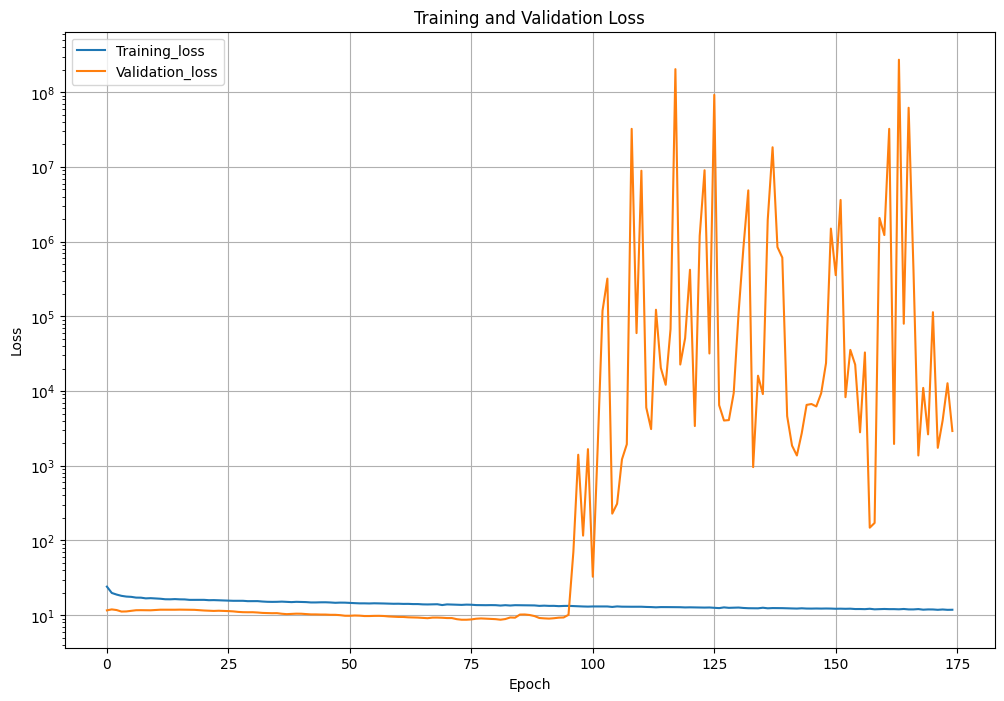

In [82]:
# Loss Plot

plot_loss(df1_history, logy=True)#, ylim=[15, 25])

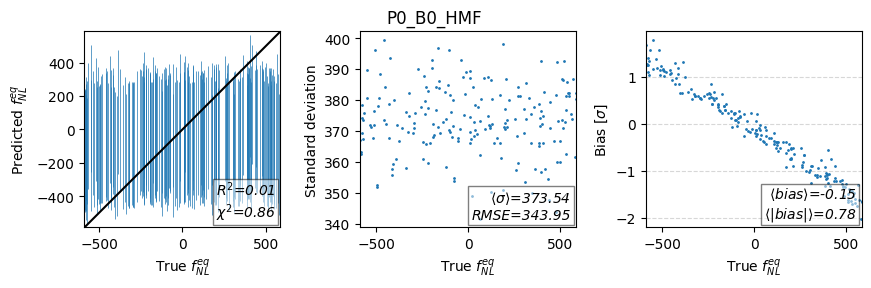

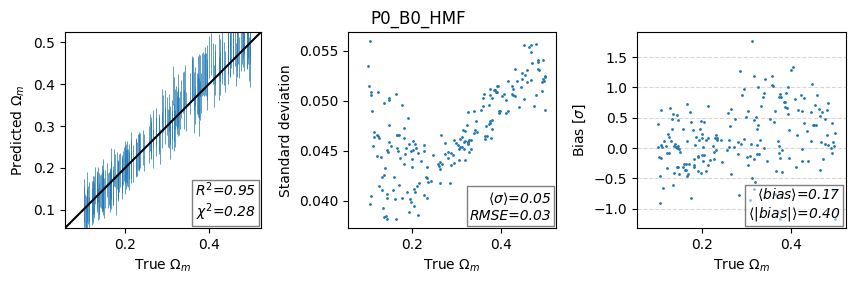

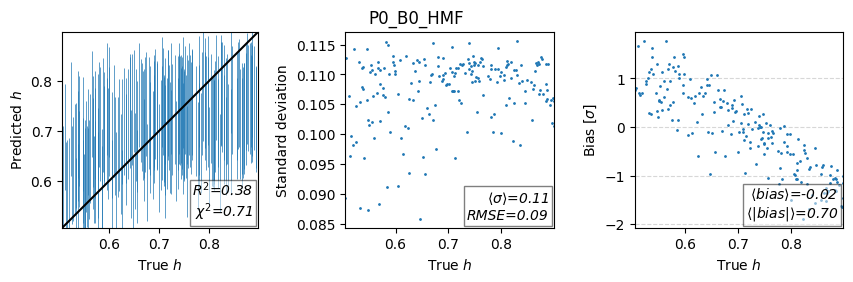

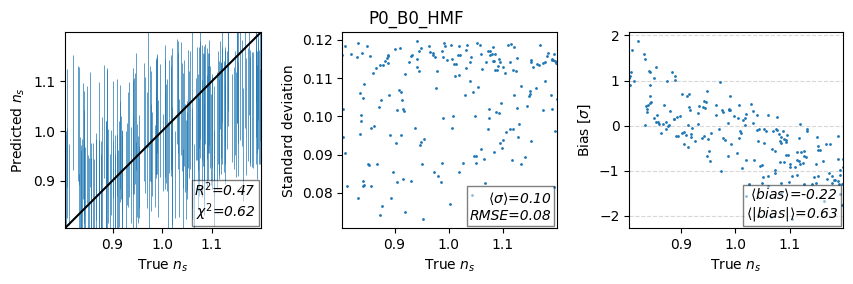

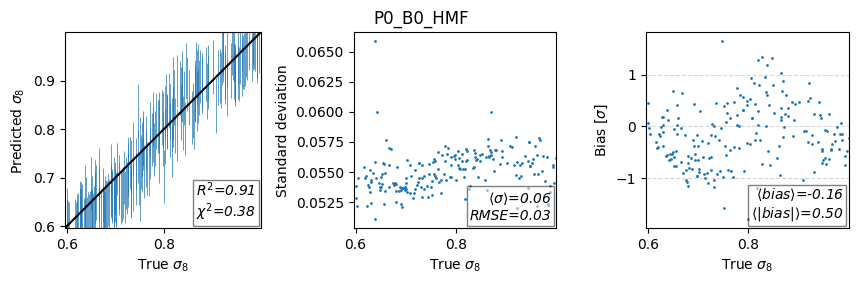

In [71]:
predictions1 = prediction(best_model1,X1_test,y1_test,mean_params,std_params,title = "P0_B0_HMF")


### Power Spectrum and Bispectrum Only

In [83]:
# Call the Data
columns = [P0, B0]
df_2 = input_data(columns,norm_lbl)


In [84]:
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = train_val_test_split(df_2 ,random_state = 5)

In [86]:
X_training_set = X2_train
tuner2 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='P0B0_pat100-reg-1')
# Running the HyperParameter Search

tuner2.search(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100000, callbacks=callback_early_stopping())




Trial 30 Complete [00h 00m 38s]
val_loss: 4.612932205200195

Best val_loss So Far: 4.137373924255371
Total elapsed time: 00h 13m 59s


In [89]:
best_hp2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp2.get('num_layers')
best_architecture = [best_hp2.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp2.get('learning_rate')
best_dropout_rate = best_hp2.get('dropout_rate')
best_base_learning_rate = best_hp2.get('learning_rate')
best_batch_size = best_hp2.get('batch_size')
best_regularization_rate =best_hp2.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")

print(tuner2.search_space_summary())
print(tuner2.results_summary())


Best Hyperparameters:
- Number of Layers: 8
- Architecture: [544, 704, 544, 480, 160, 800, 544, 352]
- Opt_Learning Rate: 0.0005728265752083151
- Base Learning Rate (CLR): 0.0005728265752083151
- Dropout Rate: 0.18090080076684292
- Batch Size: 512
- Regularization Rate:0.0008507240192307092

Search space summary
Default search space size: 14
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
l2_regularization (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'d

In [91]:
# Fitting the model
hypermodel2 = hp_model_for_dataset()
best_model2 = hypermodel2.build(best_hp2)
histories2= hypermodel2.fit(best_hp2,best_model2,
    X2_train,
    y2_train,
    validation_data=(X2_val,
                     y2_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df2_history = pd.DataFrame(histories2.history)


Cyclic lR: 0.00012987920409612954
Epoch 1/1000000
2/2 [==============================] - 4s 688ms/step - loss: 23.7865 - val_loss: 20.9288
Epoch 2/1000000
2/2 [==============================] - 1s 718ms/step - loss: 18.5421 - val_loss: 16.0191
Epoch 3/1000000
2/2 [==============================] - 0s 36ms/step - loss: 17.1926 - val_loss: 15.4222
Epoch 4/1000000
2/2 [==============================] - 0s 37ms/step - loss: 16.9131 - val_loss: 14.9534
Epoch 5/1000000
2/2 [==============================] - 0s 37ms/step - loss: 17.1818 - val_loss: 14.7945
Epoch 6/1000000
2/2 [==============================] - 0s 36ms/step - loss: 17.1070 - val_loss: 13.9853
Epoch 7/1000000
2/2 [==============================] - 0s 36ms/step - loss: 16.6599 - val_loss: 13.0348
Epoch 8/1000000
2/2 [==============================] - 0s 26ms/step - loss: 15.9947 - val_loss: 13.1315
Epoch 9/1000000
2/2 [==============================] - 0s 36ms/step - loss: 15.5359 - val_loss: 12.5019
Epoch 10/1000000
2/2 [======

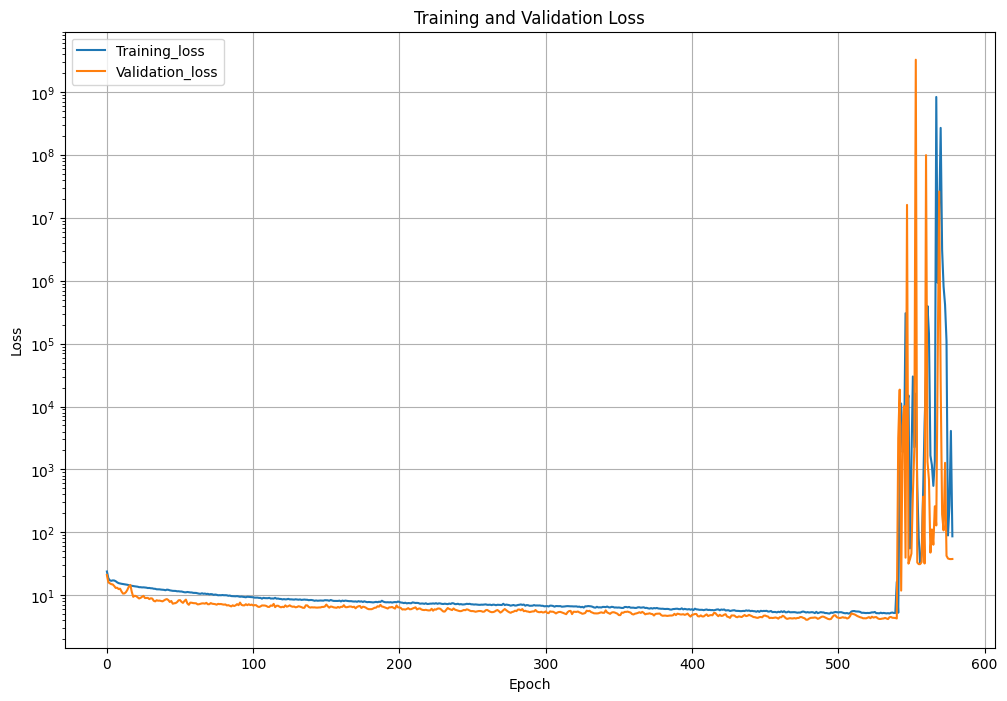

,loss,val_loss
0,23.786526,20.928816
1,18.542145,16.019144
2,17.192587,15.422153
3,16.913061,14.953407
4,17.181767,14.794548
...,...,...
574,110328.523438,42.311432
575,89.042496,38.306278
576,265.518097,37.613121
577,4091.489502,37.441971


In [92]:
# Loss Plot
plot_loss(df2_history,logy=True)#, ylim=[15, 25])
df2_history

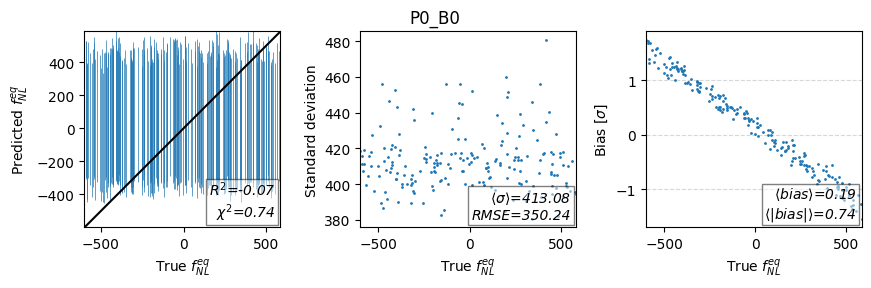

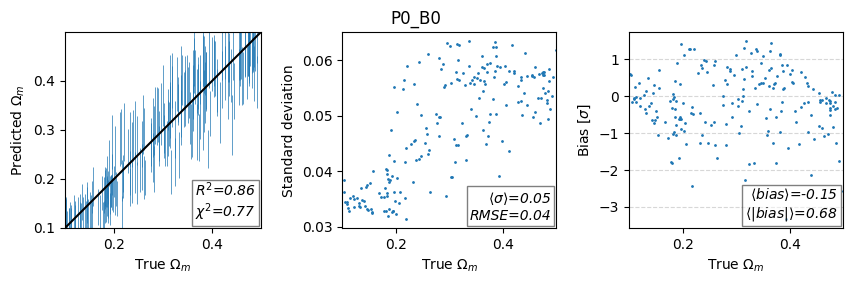

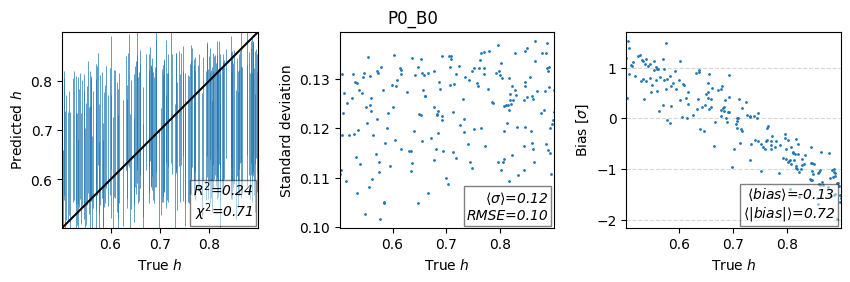

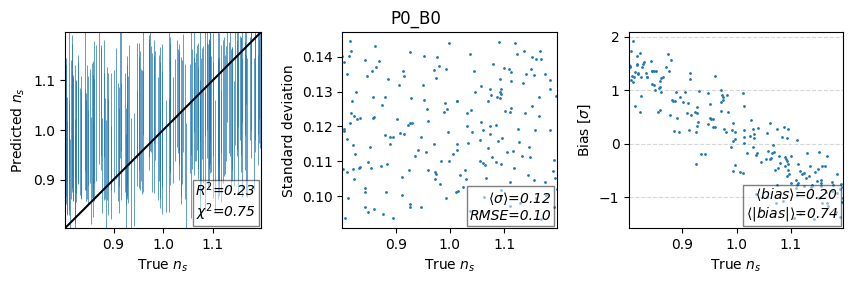

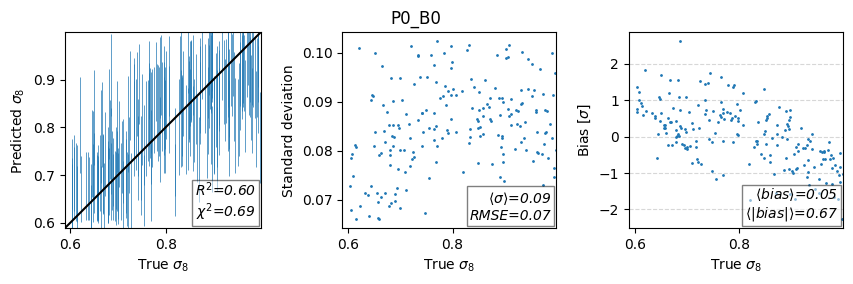

In [93]:
predictions2 = prediction(best_model2,X2_test,y2_test,mean_params,std_params,title = "P0_B0")


## PARAM vs LOSS plot

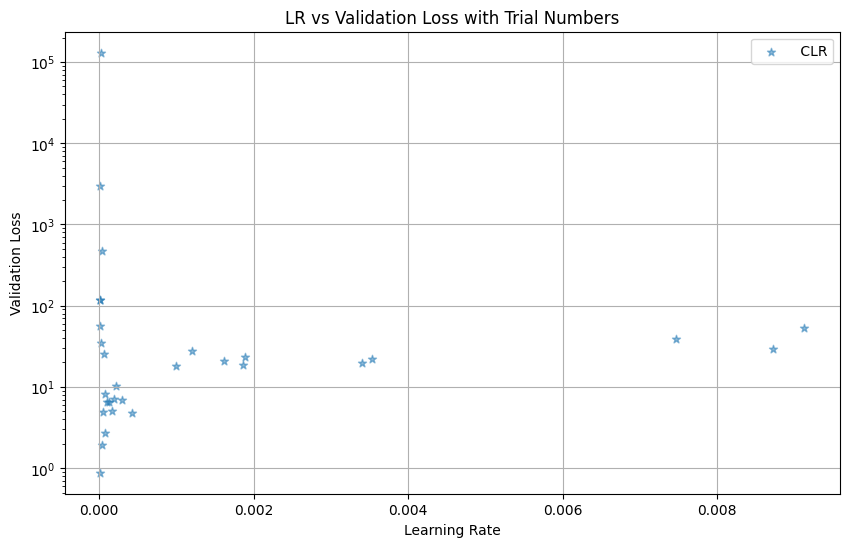

In [56]:
# Extracting dropout rates, trial numbers, and corresponding validation losses from tuner results
# dropout_rates = []
learning_rates = []
base_learning_rates = []
validation_losses = []
trial_numbers = []
dropout_rates = []
for trial_number, trial in tuner3.oracle.trials.items():
    base_learning_rate = trial.hyperparameters.values['base_learning_rate']
    learning_rate = trial.hyperparameters.values['learning_rate']
    droput_rate = trial.hyperparameters.values['dropout_rate']
    val_loss = trial.metrics.get_last_value('val_loss')
    learning_rates.append(learning_rate)
    base_learning_rates.append(base_learning_rate)
    dropout_rates.append(droput_rate)
    validation_losses.append(val_loss)
    trial_numbers.append(trial_number)
    
# print(len(validation_losses))
# print(len(base_learning_rates))
# print(len(learning_rates))
# Plotting the base learning rate vs validation loss with trial numbers as annotations
plt.figure(figsize=(10, 6))
# plt.scatter(learning_rates, validation_losses, marker='o', label='OPT_lr', alpha=0.5)
plt.scatter(base_learning_rates, validation_losses, marker='*', label=' CLR', alpha=0.5)
# plt.scatter(dropout_rates, validation_losses, marker='+', label='OPT_lr', alpha=0.5)
#####################################################################################################################################
# Adding trial numbers as annotations with adjusted placement
# for i, txt in enumerate(trial_numbers):
#     plt.annotate(txt, (base_learning_rates[i], validation_losses[i]), textcoords="offset points", xytext=(0, 8), ha='center')

# min_loss_index = validation_losses.index(min(validation_losses))
# plt.annotate(f"{trial_numbers[min_loss_index]}",(learning_rates[min_loss_index],validation_losses[min_loss_index]), 
#              textcoords="offset points", xytext=(0, 8), ha='center')

# plt.annotate(f"{trial_numbers[min_loss_index]}",(base_learning_rates[min_loss_index],validation_losses[min_loss_index]), 
#              textcoords="offset points", xytext=(0, 8), ha='center')

######################################################################################################################################

plt.title('LR vs Validation Loss with Trial Numbers')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.yscale('log')
plt.legend()
# plt.xlim(1e-5,2e-5)
plt.grid(True)
# plt.savefig("all_lr_clr_1.png")
# Display the plot
plt.show()


Are both the opt_learning_rate and the Cyclic Learning Rate (CLR) are used simultaneously to adjust the learning rate during training? Maybe The opt_learning_rate is used as the starting point for the CLR, and the CLR modulates the learning rate dynamically based on the progress of training.
Maybe this approach is allowing for a more fine-grained and adaptive adjustment of the learning rate?, potentially leading to better convergence and performance?can i show it from the plots.

Maybe this is gow it is used together:

The opt_learning_rate is set during model construction, and it serves as the initial learning rate for the optimizer.

During training, the CLR scheduler takes over and modifies the lr according to its cyclical lr pattern.

The modified lr, based on the CLR, is then used for the optimizer's updates.


Is the clr lr and batch rate being tuned independently of the other hyper parameters?


In [156]:
tf.keras.callbacks
# print(clr_triangular.history.keys())

# # Plot the learning rates
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'][:1000], clr_triangular.history['lr'][:1000])
# # plt.plot(clr_triangular.history['lr'][:1000], clr_triangular.history['loss'][:1000])

# plt.show()


<module 'tensorflow.keras.callbacks' from '/home/ubuntu/miniconda3/envs/tf/lib/python3.11/site-packages/keras/api/_v2/keras/callbacks/__init__.py'>

In [33]:
print(callback()[0])

In [41]:
clr_triangular = CyclicLR(#mode='exp_range',
                                  base_lr=max_lr/4.,
                                  max_lr=max_lr,
                                  step_size=3*4, # recommended (2-8) x (training iterations in epoch)
                                  gamma=0.99994)
clr_triangular
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
        restore_best_weights=True,
        verbose=1)
early_stopping

In [42]:
callback()

In [85]:
hp_base_learning_rate = best_hp3.Float('base_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")
'base_learning_rate'

'base_learning_rate'

# Random Stuff

In [35]:
y3_test.shape[-1]

5

In [27]:
predictions = best_model3.predict(X3_test, verbose=0)
df_predictions = pd.DataFrame(predictions)
df_predictions

y_mean_predict = df_predictions[df_predictions.columns[:5]]

y_cov = df_predictions[df_predictions.columns[5:]]
cholesky_matrix = tfpmath.fill_triangular(y_cov)
# cholesky_matrix




In [28]:
cov_matrix = tf.matmul(cholesky_matrix,cholesky_matrix, transpose_b=True)
inv_cov = tf.linalg.inv(cov_matrix)
std_devs = tf.sqrt(tf.linalg.diag_part(cov_matrix))
# tf.linalg.diag_part(inv_cov)

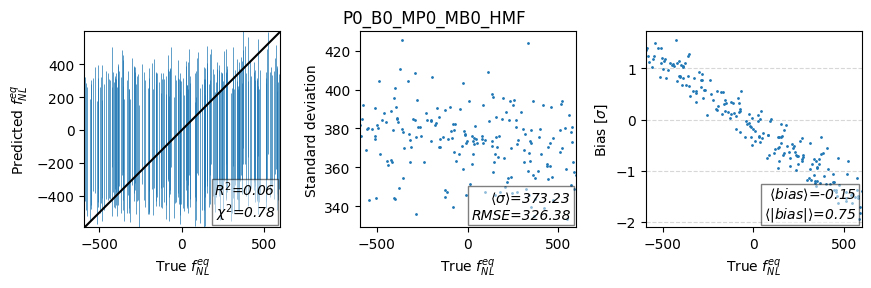

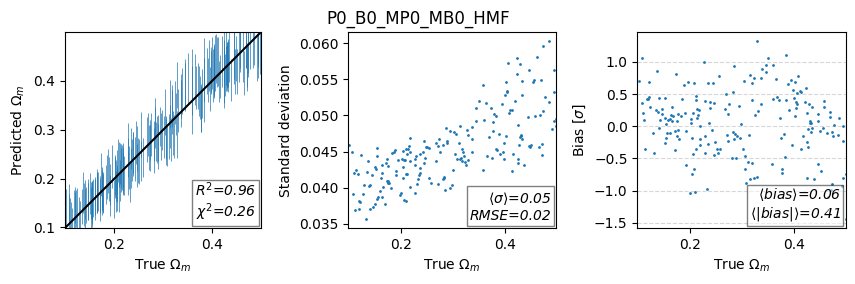

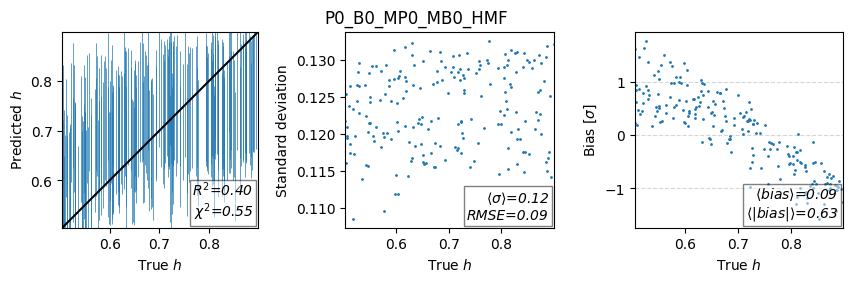

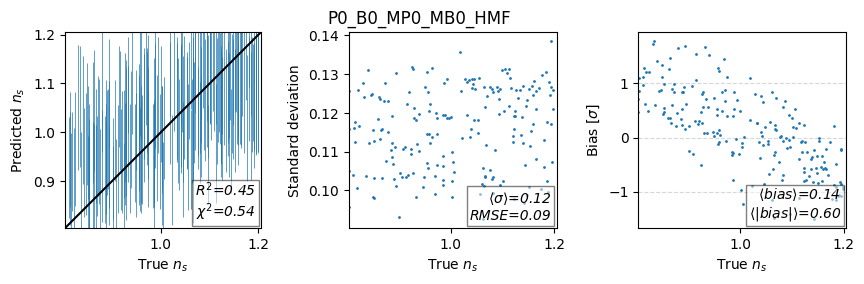

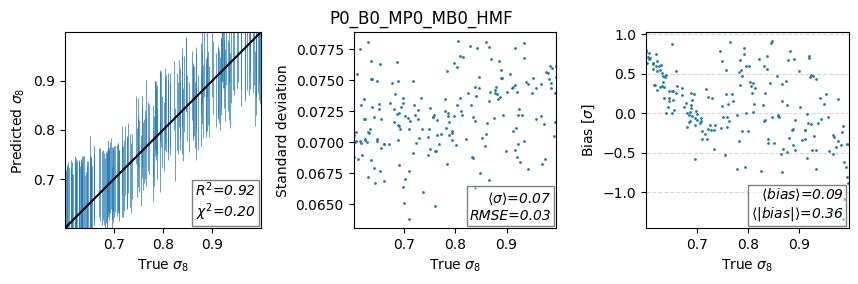

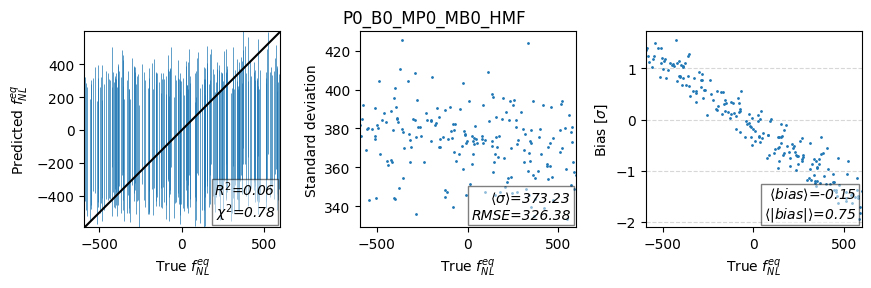

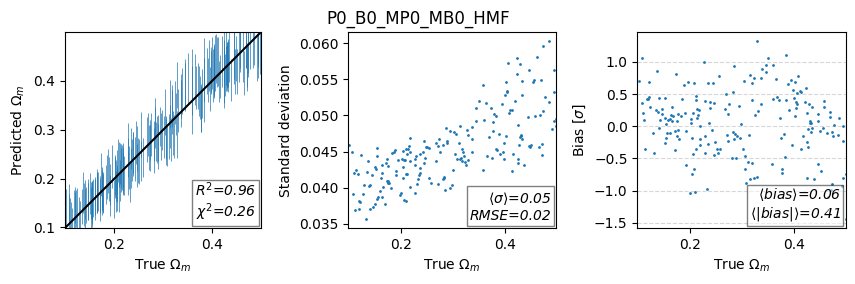

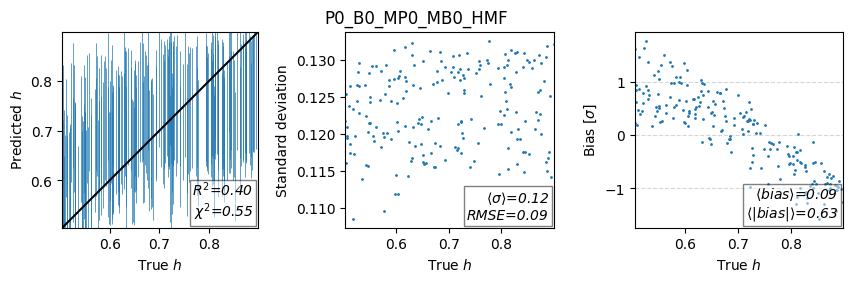

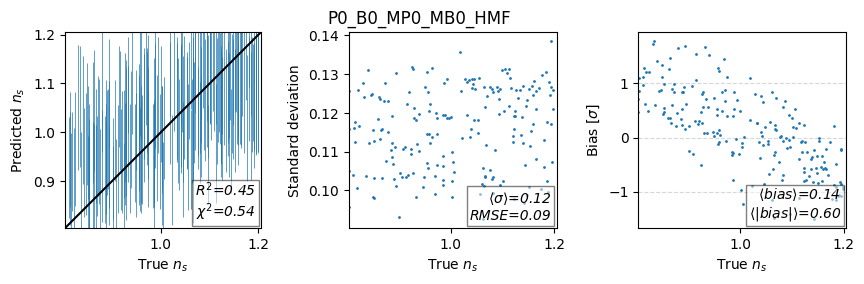

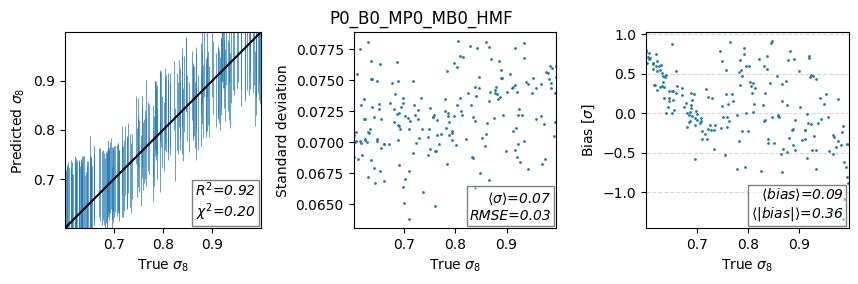

In [29]:
y_true = prediction(best_model3,X3_test,y3_test,mean_params,std_params,title = "P0_B0_MP0_MB0_HMF")[0]
y_pred = prediction(best_model3,X3_test,y3_test,mean_params,std_params,title = "P0_B0_MP0_MB0_HMF")[3]

In [30]:
row = (y_pred.iloc[:, -15:])
row
# tfpmath.fill_triangular(row)
# pd.DataFrame(y_pred)
# pd.DataFrame(y_true)

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.456405,0.251184,0.004374,-0.306119,-0.058146,1.088219,0.844623,-0.456152,-0.065574,-0.126946,0.066449,0.366832,1.061937,-0.274549,-0.186465
1,0.554755,0.209533,-0.045216,-0.256256,-0.039965,1.060274,0.925986,-0.492596,-0.213213,-0.028459,0.043629,0.455329,0.985912,-0.077142,-0.209637
2,0.502487,0.205670,-0.081166,-0.261680,-0.094243,1.069762,0.822173,-0.553935,-0.278045,-0.046608,0.081514,0.431858,0.970778,-0.067949,-0.229967
3,0.440487,0.235619,-0.014822,-0.299884,-0.060575,1.128209,0.832850,-0.475833,-0.066094,-0.161599,0.071692,0.366400,1.037905,-0.310336,-0.163562
4,0.438307,0.217940,-0.023594,-0.363266,-0.113372,1.022313,0.729598,-0.503337,-0.111593,-0.174606,0.128716,0.309644,1.061622,-0.187531,-0.340544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.527639,0.227015,-0.084772,-0.230936,-0.091617,1.095847,0.870881,-0.564859,-0.289842,0.021328,0.048378,0.452387,0.993015,-0.074271,-0.262896
196,0.441746,0.239047,-0.041410,-0.299090,-0.096883,1.120214,0.741908,-0.602678,-0.177377,-0.131375,0.088913,0.371018,1.085688,-0.216910,-0.180949
197,0.559193,0.204451,-0.046026,-0.252204,-0.044527,1.075478,0.943648,-0.523820,-0.222292,-0.045661,0.038018,0.485032,1.014792,-0.072841,-0.181632
198,0.442128,0.258016,-0.156577,-0.295179,-0.135087,1.141194,0.798938,-0.691841,-0.335511,-0.080365,0.063586,0.392973,1.041943,-0.151938,-0.302237


In [34]:
tfpmath.fill_triangular(row)
columns_to_check = [0, 5, 6, 11, 12]

# Check if any of the specified columns have negative values
negative_values_check = row.iloc[:, columns_to_check].lt(0).any()
print("Columns with negative values:", negative_values_check[negative_values_check].index.tolist())

Columns with negative values: []


In [44]:
num_of_parameters = (tf.math.sqrt(tf.cast(8 * y_pred.shape[-1] + 9, dtype=tf.float16)) - 3) / 2
num_of_parameters = tf.cast(num_of_parameters,dtype=tf.int32)

print(num_of_parameters.numpy())

means_pred, pseudo_sigmas_pred = tf.split(y_pred,

                                          num_or_size_splits=[num_of_parameters,
                                                              tf.cast(num_of_parameters*(num_of_parameters+1)/2, dtype=tf.int32)],
                                          axis=-1)

means_pred_df = pd.DataFrame(means_pred)

L = tfpmath.fill_triangular(pseudo_sigmas_pred)
# cov = tf.matmul(L,L,transpose_b= True)

dist_pred = distributions.MultivariateNormalTriL(

    loc=means_pred,

    scale_tril=L,
)
loglkl= dist_pred.log_prob(y_true)
# tf.math.reduce_mean(loglkl)
# # pseudo_sigmas_pred_df = pd.DataFrame(pseudo_sigmas_pred)
# # pseudo_sigmas_pred_df
 
# # pd.DataFrame(L[58])
# #    #Cov = tf.matmul(L, L, transpose_b=True)






# dist_pred.p(10)
# # y_sigma_predict = tf.sqrt(tf.linalg.diag_part(L))
# # # pd.DataFrame(y_sigma_predict)
# # loglkl = dist.prob(means_pred)

-loglkl
# # -tf.math.reduce_mean(loglkl)


# # # -tf.math.reduce_mean(loglkl)


5


<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([1.00881683e+02, 5.49823906e+04, 5.12178711e+02, 6.77505469e+04,
       8.56914219e+04, 1.39850010e+04, 4.20116650e+03, 2.06019989e+02,
       9.67982656e+04, 1.70039785e+04, 6.15740078e+04, 3.73310840e+03,
       1.01989938e+05, 2.36098511e+03, 1.12324078e+05, 1.10484703e+05,
       2.02782828e+05, 5.97693984e+04, 8.77502637e+03, 1.60532305e+04,
       8.11568237e+02, 3.87732891e+04, 7.79633906e+04, 9.25046250e+04,
       2.90871855e+04, 2.53691816e+04, 1.00679008e+05, 1.07237867e+05,
       1.59531672e+05, 1.62293594e+04, 1.75606391e+05, 9.29072461e+03,
       1.09129776e+02, 2.01695488e+04, 1.49623062e+05, 1.27225479e+04,
       2.50284672e+01, 4.89949341e+02, 1.06903750e+05, 2.06700219e+05,
       8.03230156e+04, 1.10528994e+04, 4.06401602e+04, 4.74817969e+04,
       1.12973906e+05, 8.83587036e+01, 1.16229680e+05, 6.13636094e+04,
       8.20710938e+04, 3.63760430e+04, 3.41880156e+04, 7.14922031e+04,
       3.25065352e+04, 6.5161

In [148]:
# exp = -dist_pred.log_prob(y_true)
# # tf.math.reduce_logsumexp(exp)
# def log_sum_exp(x, axis=None):
#     x_max = tf.reduce_max(x, axis=axis, keepdims=True)
#     print(x_max)
#     print(x)
    
#     return tf.math.log(tf.reduce_sum(tf.exp(x - x_max), axis=axis, keepdims=True)) + x_max
# log_sum_exp(exp, axis=0)
 

tf.Tensor([4859.586], shape=(1,), dtype=float32)
tf.Tensor(
[1355.4955     33.452938  109.69204   143.87857    29.515007  646.1421
   34.085323  508.507     266.59717   546.925      45.90166    21.842793
  745.85474  3108.6199   1274.7445     52.16677    72.90593    28.188183
 2524.362      60.826324 1439.3314   1635.3947    578.4129    556.348
   68.191345   78.50515  1599.1163     25.307066  221.22827  1016.66034
 1005.58954   425.3844    378.23114    16.848722   38.930824 1561.0281
  306.3399    143.31833   558.9219     71.17944   175.50458    29.523783
  621.4368    483.667      26.991743 1991.8052    314.10953   425.65158
  285.00192   199.31999    33.7011     75.473495  235.11739    20.735878
  446.51498    37.202213  235.24016   251.28111    64.97879   894.7472
  617.1786     86.51249    64.41678    43.17542    33.403854  161.01552
 1784.3524    190.37859   105.06152   255.57637  2135.71     2102.9958
   52.459663  217.41994  3997.954    1470.438     288.71906  1349.3685
  112.8

<tf.Tensor: shape=(), dtype=float32, numpy=-616.2518>

plan is to find tge mvn distribution for the true value and the predicted value and then  minimize the the kullback divergence loss

<tf.Tensor: shape=(), dtype=float32, numpy=-4859.586>